### Initially just some playing round with Keras

Input: Image<br>
Initial output: center of hand<br>
Is anchors needed? So the prediction is an offset?<br>


In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras import backend as K
from keras.layers import *
from keras.initializers import TruncatedNormal
from keras.regularizers import l2
from keras.callbacks import Callback
from keras import optimizers
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import time

Using TensorFlow backend.


In [ ]:
K.tensorflow_backend._get_available_gpus()

In [ ]:
from SqueezeDetHelpers import fire_layer, binary_crossentropy, keras_binary_crossentropy

In [ ]:
print(tf.__version__)

- Grid over image size
    - Grid nodes will be anchors
    - Net predicts: Probability of class at anchor, and offset from anchor.
        - In later versions, several offsets will be predicted at each offset.
- The net is fully convolutional, meaning the output must be feature maps.
    - Amount of output filters will then be confidence+x_offset+y_offset
    - filter size will be the size of the anchor grid

In [ ]:
num_out = 3

In [ ]:
DATA_DIR = r"./data"
ANNOTATION_FILE = r"annot"
annotation = os.path.join(DATA_DIR, ANNOTATION_FILE)
print(annotation)

In [ ]:
EPSILON = 1e-16

In [ ]:
BATCHSIZE = 16

In [ ]:
HEIGHT = 320
WIDTH = 320
CHANNELS = 3

In [ ]:
WEIGHT_DECAY = 0 # 0.001
KEEP_PROB = 0.5
CLASSES = 1

In [ ]:
ANCHOR_HEIGHT = 20
ANCHOR_WIDTH = 20

In [ ]:
LABEL_WEIGHT = 1.0
OFFSET_LOSS_WEIGHT = 1.0
OFFSET_WEIGHT = 40.0

In [ ]:
VALIDATION_SPLIT = 0.3

In [ ]:
num_anchor_nodes = ANCHOR_HEIGHT * ANCHOR_WIDTH

print(f"Out dim: {ANCHOR_HEIGHT}x{ANCHOR_WIDTH}")
print(f"Number of anchor nodes: {num_anchor_nodes}")

In [ ]:
def set_anchors():
    
    #anchors = np.zeros((num_anchor_nodes, 2))
    anchors = np.zeros((ANCHOR_HEIGHT, ANCHOR_WIDTH, 2), dtype=np.uint32)
    print(f"Number of anchors: {num_anchor_nodes}")
    
    print(f"Anchor dimension: ({ANCHOR_HEIGHT}, {ANCHOR_WIDTH})")
    print(f"Anchor shape: {anchors.shape}")
    
    #xs = np.arange(PIXELS_BETWEEN_ANCHORS, WIDTH, PIXELS_BETWEEN_ANCHORS)
    #ys = np.arange(PIXELS_BETWEEN_ANCHORS, HEIGHT, PIXELS_BETWEEN_ANCHORS)
    
    x_start = WIDTH / (ANCHOR_WIDTH + 1)
    x_end = WIDTH - x_start
    y_start = HEIGHT / (ANCHOR_HEIGHT + 1)
    y_end = HEIGHT - y_start
    xs = np.linspace(x_start, x_end, num=ANCHOR_WIDTH, dtype=np.uint32)
    ys = np.linspace(y_start, y_end, num=ANCHOR_HEIGHT, dtype=np.uint32)
    
    """
    counter = 0
    for cx in range(len(xs)):
        for cy in range(len(ys)):
            anchors[counter] = [xs[cx], ys[cy]]
            counter += 1
    """
    
    for ix in range(ANCHOR_HEIGHT):
        for iy in range(ANCHOR_WIDTH):
            anchors[ix, iy] = (xs[ix], ys[iy])
    
    return anchors
    
anchs = set_anchors()
anchs[2, 2]

In [ ]:
input_layer = Input(shape=(HEIGHT, WIDTH, CHANNELS), name="input")
print(f"input: {input_layer.shape}")

conv1 = Conv2D(name='conv1', filters=128, kernel_size=(3, 3), strides=(2, 2), activation=None, padding="SAME",
               use_bias=False,
               kernel_initializer=TruncatedNormal(stddev=0.01),
               #kernel_regularizer=l2(WEIGHT_DECAY),
               )(input_layer)
print(f"conv1: {conv1.shape}")

bn = BatchNormalization(name='bn')(conv1)
act = Activation('relu', name='act')(bn)

pool1 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='SAME', name="pool1")(act)
print(f"pool1: {pool1.shape}")

fire1_1 = fire_layer(name="fire1_1", input=pool1, s1x1=32, e1x1=128, e3x3=128, weight_decay=WEIGHT_DECAY)
print(f"fire1_1: {fire1_1.shape}")

fire1_2 = fire_layer(name="fire1_2", input=fire1_1, s1x1=32, e1x1=128, e3x3=128, weight_decay=WEIGHT_DECAY)
print(f"fire1_2: {fire1_2.shape}")

#fire1_3 = fire_layer(name="fire1_3", input=fire1_2, s1x1=32, e1x1=128, e3x3=128, weight_decay=WEIGHT_DECAY)
#print(f"fire1_3: {fire1_3.shape}")

pool2 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='SAME', name="pool2")(fire1_2)
print(f"pool2: {pool2.shape}")

fire2_1 = fire_layer(name="fire2_1", input=pool2, s1x1=48, e1x1=192, e3x3=192, weight_decay=WEIGHT_DECAY)
print(f"fire2_1: {fire2_1.shape}")

fire2_2 = fire_layer(name="fire2_2", input=fire2_1, s1x1=48, e1x1=192, e3x3=192, weight_decay=WEIGHT_DECAY)
print(f"fire2_2: {fire2_2.shape}")

#fire2_3 = fire_layer(name="fire2_3", input=fire2_2, s1x1=48, e1x1=192, e3x3=192, weight_decay=WEIGHT_DECAY)
#print(f"fire2_3: {fire2_3.shape}")

pool3 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='SAME', name="pool3")(fire2_2)
print(f"pool3: {pool3.shape}")

fire3_1 = fire_layer(name="fire3_1", input=pool3, s1x1=48, e1x1=192, e3x3=192, weight_decay=WEIGHT_DECAY)
print(f"fire3_1: {fire3_1.shape}")

fire3_2 = fire_layer(name="fire3_2", input=fire3_1, s1x1=48, e1x1=192, e3x3=192, weight_decay=WEIGHT_DECAY)
print(f"fire3_2: {fire3_2.shape}")

"""
fire4 = fire_layer(name="fire4", input=pool2, s1x1=16, e1x1=64, e3x3=64, weight_decay=WEIGHT_DECAY)
print(f"fire4: {fire4.shape}")

fire5 = fire_layer(name="fire5", input=fire4, s1x1=16, e1x1=64, e3x3=64, weight_decay=WEIGHT_DECAY)
print(f"fire5: {fire5.shape}")

fire6 = fire_layer(name="fire6", input=fire5, s1x1=16, e1x1=64, e3x3=64, weight_decay=WEIGHT_DECAY)
print(f"fire6: {fire6.shape}")
"""

"""
conv2 = Conv2D(name='conv2', filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="SAME",
               #filters=len(ANCHORS),
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.001),
               #kernel_regularizer=l2(WEIGHT_DECAY),
               )(pool2)
print(f"conv2: {conv2.shape}")
"""

"""
conv3 = Conv2D(name='conv3', filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="SAME",
               #filters=len(ANCHORS),
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.001),
               #kernel_regularizer=l2(WEIGHT_DECAY),
               )(conv2)
print(f"conv3: {conv3.shape}")

conv4 = Conv2D(name='conv4', filters=256, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding="SAME",
               #filters=len(ANCHORS),
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.001),
               #kernel_regularizer=l2(WEIGHT_DECAY),
               )(conv3)
print(f"conv4: {conv4.shape}")
"""

"""
preds = Conv2D(name='preds', filters=num_out, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid', padding="SAME",
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.001),
               #kernel_regularizer=l2(WEIGHT_DECAY)
               )(fire6)
print(f"preds: {preds.shape}")
"""

#drop1 = Dropout(rate=KEEP_PROB, name="drop1")(fire6)

pred_conf = Conv2D(name='pred_conf', filters=1, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid', padding="SAME",
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.01),
               #kernel_regularizer=l2(WEIGHT_DECAY)
               )(fire3_2)
print(f"pred_conf: {pred_conf.shape}")

pred_offset = Conv2D(name='pred_offset', filters=2, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid', padding="SAME",
               #use_bias=True,
               kernel_initializer=TruncatedNormal(stddev=0.01),
               #kernel_regularizer=l2(WEIGHT_DECAY)
               )(fire3_2)
print(f"pred_offset: {pred_offset.shape}")

#preds = Concatenate()([pred_conf, pred_offset])
preds = concatenate([pred_conf, pred_offset])
print(f"preds: {preds.shape}")

cross-entropy: q * -log(p) + (1-q) * -log(1-p)

In [ ]:
def loss(y_true, y_pred):
    # We are predicting a batchsize x anchorwidth x anchorheight x 3 output.
    c_predictions = y_pred[:, :, :, 0]
    c_labels = y_true[:, :, :, 0]
    
    pred_offset_x = 2 * (y_pred[:, :, :, 1] - 0.5) * OFFSET_WEIGHT
    pred_offset_y = 2 * (y_pred[:, :, :, 2] - 0.5) * OFFSET_WEIGHT
    
    true_offset_x = y_true[:, :, :, 1]
    true_offset_y = y_true[:, :, :, 2]
    
    #offset_mask = K.copy(true_offset[:,:,:,0])
    #offset_mask = K.abs(true_offset[:,:,:,0]) + K.abs(true_offset[:,:,:,0])
    
    #offset_mask[offset_mask!=0] = 1.0
    
    #offset_mask = K.zeros((BATCHSIZE, ANCHOR_WIDTH, ANCHOR_HEIGHT))
    #m = K.where((true_offset[:,:,:,0]!=0) | (true_offset[:,:,:,1]!=0))
    #offset_mask[true_offset[:,:,:,0]!=0] = 1.0
    #offset_mask[true_offset[:,:,:,1]!=0] = 1.0
    
    g_x = K.less(true_offset_x, 0)
    l_x = K.greater(true_offset_x, 0)
    g_y = K.greater(true_offset_y, 0)
    l_y = K.less(true_offset_y, 0)
    
    g_x_i = K.cast(g_x, dtype='float32')
    l_x_i = K.cast(l_x, dtype='float32')
    g_y_i = K.cast(g_y, dtype='float32')
    l_y_i = K.cast(l_y, dtype='float32')

    mask_offset_x = K.clip(g_x_i + l_x_i, 0, 1.0)
    mask_offset_y = K.clip(g_y_i + l_y_i, 0, 1.0)
    #zeroes = K.zeros_like(true_offset_x)
    #ones = K.ones_like(true_offset_x)
    #mask_offset = K.where(mask_offset_bool, ones, zeroes)
    
    #pred_conf = K.sigmoid(c_predictions)
    #pred_conf = c_predictions

    #c_loss = K.sum(
    #    -(c_labels * K.log(pred_conf + EPSILON) + (1-c_labels) * K.log(1-pred_conf + EPSILON))
    #) / BATCHSIZE
    
    #c_loss = K.sum(
    #    c_labels * (-K.log(c_predictions + EPSILON)) + (1-c_labels) * (-K.log(1-c_predictions + EPSILON)) * c_labels
    #) / BATCHSIZE
    
    #c_loss = K.sum(
    #    K.maximum(K.abs(c_predictions), 0) - c_predictions * c_labels + K.log(1 + K.exp(-K.abs(c_predictions)))
    #) / BATCHSIZE
    
    #c_loss = K.sum(
    #    K.maximum(K.abs(c_predictions), 0) - c_predictions * c_labels + K.log(1 + K.exp(-K.abs(c_predictions)))
    #, axis=0) / BATCHSIZE

    #c_loss = K.sum(c_loss) / (ANCHOR_HEIGHT * ANCHOR_WIDTH)
    
    #diff = K.abs(c_labels - c_predictions)
    #c_loss = 2 * (K.sigmoid(diff) - 0.5)
    
    #c_loss = K.sum(
    #    K.sigmoid(
    #        K.abs(
    #            c_labels - c_predictions
    #        )
    #    )
    #) / BATCHSIZE
    
    #c_loss = K.sum(
    #    2 * K.sigmoid(
    #        K.abs(
    #            c_labels - c_predictions
    #        )
    #    ) - 0.5
    #) / BATCHSIZE
    
    #c_loss = K.sum(
    #    K.abs(
    #        c_labels - c_predictions
    #    )
    #)
    
    
    #c_loss = K.sig
    
    # number of labels
    num_labels = K.sum(c_labels)  # Accounts for batch size
    num_non_labels = ANCHOR_WIDTH * ANCHOR_HEIGHT - num_labels
    
    # Loss matrix for all entries
    loss_m_all = keras_binary_crossentropy(c_labels, c_predictions, EPSILON)
    
    # Loss matrix for the correct label
    loss_m_label = keras_binary_crossentropy(c_labels, c_predictions, EPSILON) * c_labels
    
    # Loss matrix for non labels
    loss_m_nonlabel = loss_m_all - loss_m_label
    
    # Summing and adding weight to label loss
    c_loss_label = K.sum(
        loss_m_label
    ) / num_labels
    
    # summing and adding weight to non label loss
    c_loss_nonlabel = K.sum(
        loss_m_nonlabel
    ) / num_non_labels
    
    c_loss = c_loss_label * LABEL_WEIGHT + c_loss_nonlabel * (1 / LABEL_WEIGHT)
    
    
    o_loss_x = K.sum(
        #K.pow(true_offset_x - pred_offset_x, 2) * mask_offset_x
        #K.abs(true_offset_x - pred_offset_x) * mask_offset_x
        K.square((true_offset_x - pred_offset_x) * mask_offset_x)
    ) / num_labels
    
    o_loss_y = K.sum(
        #K.pow(true_offset_y - pred_offset_y, 2) * mask_offset_y
        #K.abs(true_offset_y - pred_offset_y) * mask_offset_y
        K.square((true_offset_y - pred_offset_y) * mask_offset_y)
    ) / num_labels
    
    o_loss = (o_loss_x + o_loss_y) * OFFSET_LOSS_WEIGHT
    
    # Only on correct label
    #o_loss = K.sum(
    #    #K.pow(pred_offset - true_offset, 2) * offset_mask
    #    (K.pow(
    #        true_offset[:, :, :, 0] - pred_offset[:, :, :, 0], 2
    #    ) + K.pow(
    #        true_offset[:, :, :, 1] - pred_offset[:, :, :, 1], 2
    #    ))# * offset_mask
    #) / BATCHSIZE / num_labels
    
    #l2_loss = K.sum(
    #    2 * K.sigmoid (
    #        K.sqrt(
    #            K.pow(y_true_offset[0] - y_true_offset[0], 2) + K.pow(y_true_offset[1] - y_pred_offset[1], 2)
    #        )
    #    ) - 0.5
    #) / BATCHSIZE
    
    #l2_loss = K.sum(
    #    2 * K.sigmoid(
    #        K.pow(y_pred_offset - y_true_offset, 2)
    #    ) - 0.5
    #) / BATCHSIZE
    
    
    #o_loss = 0
    
    total_loss = o_loss + c_loss
    
    return total_loss

#y_true_test = np.zeros((BATCHSIZE, ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))
#y_pred_test = np.zeros((BATCHSIZE, ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))
#l = loss(y_pred_test, y_true_test)
#print(l)

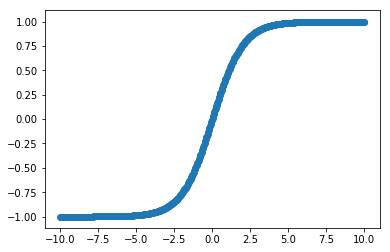

In [6]:
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

x = np.linspace(-10, 10, 500)
y = 2 * (sigmoid(x) - 0.5)
plt.scatter(x, y)

$−(ylog(p)+(1−y)log(1−p))$

https://stackoverflow.com/questions/48951109/keras-custom-binary-cross-entropy-loss-function-get-nan-as-output-for-loss<br>
$max(x, 0) - x * z + log(1 + exp(-abs(x)))$<br>
$max(p, 0) - p * y + log(1 + exp(-abs(p)))$

In [ ]:
c_labels = 1
pred_conf = 0

diff = abs(c_labels - pred_conf)
l = (sigmoid(diff) - 0.5) * 2
#print(l)

#pred_conf = sigmoid(pred_conf)
#ll = -(c_labels * np.log(pred_conf + EPSILON) + (1 - c_labels) * np.log(1-pred_conf + EPSILON))
#print(ll)

lll = np.max(np.abs(pred_conf), 0) - pred_conf * c_labels + np.log(1 + np.exp(-np.abs(pred_conf)))
print(lll)

In [ ]:
y_t = np.zeros((BATCHSIZE, ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))
y_t[:, 10, 10, 0] = 1.0
print(y_t.shape)
#np.max(np.maximum(-y_t, 0))
np.sum(y_t) / BATCHSIZE

In [ ]:
arr1 = np.array([[1, 2, 3],
                 [1, 2, 3],
                 [1, 2, 3]])

arr2 = np.array([[4, 5, 6],
                 [4, 5, 6],
                 [4, 5, 6]])

res = np.concatenate((arr1, arr2), axis=-1)
print(arr1.shape)
print(res)

In [ ]:
def np_loss(y_true, y_pred, bs):
    #c_predictions = y_pred[:, :, :, 0]
    #c_labels = y_true[:, :, :, 0]

    c_predictions = y_pred
    c_labels = y_true

    
    # number of labels
    num_labels = np.sum(c_labels)
    num_non_labels = 3 * 3 - num_labels   # ANCHOR_WIDTH and ANCHOR_HEIGHT
    
    # Loss matrix for all entries
    loss_m_all = binary_crossentropy(c_labels, c_predictions, EPSILON)
    
    # Loss matrix for the correct label
    loss_m_label = binary_crossentropy(c_labels, c_predictions, EPSILON) * c_labels
    #print(loss_m_label)
    
    # Loss matrix for non labels
    loss_m_nonlabel = loss_m_all - loss_m_label
    #print(loss_m_nonlabel)
    
    # Summing and adding weight to label loss
    c_loss_label = np.sum(
        loss_m_label
    ) / bs / num_labels
    
    # summing and adding weight to non label loss
    c_loss_nonlabel = np.sum(
        loss_m_nonlabel
    ) / bs / num_non_labels
    
    print(f"Label loss: {c_loss_label}")
    print(f"Non label loss: {c_loss_nonlabel}")
    
    c_loss = c_loss_label * LABEL_WEIGHT + c_loss_nonlabel * (1 / LABEL_WEIGHT)
    
    return c_loss


#labels_test = np.copy(labels[-20:])
#print(labels_test[:, :, :, 0].shape)
#labels_test[:, :, :, 0] = 2
#np_loss(labels[:20], labels_test)
#print(np_loss(labels[-5:], labels[:5], 5))
#print(np_loss(labels[:20], labels[:20], 20))


true_test = np.array([[0, 0, 0],
                      [0, 1, 0],
                      [0, 0, 0]])

pred_test = np.array([[0, 1, 0],
                      [0, 1, 0],
                      [0, 0, 0]])

np_loss(true_test, pred_test, bs=1)

In [ ]:
#sess = tf.InteractiveSession()

"""
with tf.Session() as s:
    # Some tensor we want to print the value of
    y_true_test = tf.zeros((BATCHSIZE, ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))
    y_pred_test = tf.zeros((BATCHSIZE, ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))
    s.run(tf.global_variables_initializer())
    
    l = loss(y_pred_test, y_true_test)
    # Add print operation
    print(s.run(l))
"""

In [ ]:
c_labels = 0
c_predictions = 1
c_loss = (c_labels * (-np.log(c_predictions + EPSILON))) + (1-c_labels) * (-np.log(1-c_predictions + EPSILON))
print(c_loss)

In [ ]:
#model = Model(inputs=input_layer, outputs=preds)
#model.compile(loss='mse', optimizer='adam')
#model.compile(loss=loss, optimizer='adam')

In [ ]:
def load_data():
    
    with open(annotation, 'r') as f:
        lines = f.readlines()
    
    gt = [(None, None)] * len(lines)
    gt = np.zeros((len(lines), 2))
    
    for l in lines:
        obj = l.split(',')
        pic_id = int(obj[0].split('.')[0])
        x = int(obj[1])
        y = int(obj[2])
        
        gt[pic_id] = (x, y)

    images = []
    
    for fi in os.listdir(DATA_DIR):
        if not fi.endswith('jpg'):
            continue
        im = cv2.imread(os.path.join(DATA_DIR, fi))
        images.append(im)
    
    return gt, images

labels_clean, images_clean = load_data()

In [ ]:
def closest_anchor_map(x, y, anchor_coords):
    """ Create a anchor_height x anchor_width x 3 map.
        First entry is 1 if the anchor point is closest to true point. Zero otherwise.
        Second is x offset.
        Third is y offset. """
    closest = 10000
    closest_x = None
    closest_y = None
    closest_x_offset = None
    closest_y_offset = None
    
    res = np.zeros((ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))
    for ix in range(ANCHOR_HEIGHT):
        for iy in range(ANCHOR_WIDTH):
            p_x, p_y = anchor_coords[ix, iy]
            dist = np.sqrt( (x - p_x)**2 + (y - p_y)**2 )
            #res[ix, iy, 1:] = (x - p_x, y - p_y)
            if dist < closest:
                closest = dist
                closest_x = ix
                closest_y = iy
                closest_x_offset = (x - p_x)
                closest_y_offset = (y - p_y)
    
    #print(f"({closest_x}, {closest_y}) -> {anchor_coords[closest_x, closest_y]}")
    res[closest_x, closest_y, 0] = 1
    res[closest_x, closest_y, 1:] = (closest_x_offset, closest_y_offset)
    
    return res
        
test_map = closest_anchor_map(20, 30, anchs)
print(test_map.shape)
print(np.count_nonzero(test_map[:,:, 0]))
print(np.mean(test_map[:, :, 1]))
print(np.mean(test_map[:, :, 2]))
anc_indicies = np.where(test_map[:, :, 0] == test_map[:, :, 0].max())
print(test_map[anc_indicies[0], anc_indicies[1]])
anchor_point = test_map[anc_indicies[0], anc_indicies[1]][:,1:][0]
print(anchs.shape)

In [ ]:
def load_data_with_anchors():
    # load images
    # labels will be:
    #   anchor_height x anchor_width x 3
    #     the last 3 entries is: 1 if closest gridpoint to a point. x and y offsets to closest point.
    with open(annotation, 'r') as f:
        lines = f.readlines()
    
    gt = np.zeros((len(lines), ANCHOR_HEIGHT, ANCHOR_WIDTH, 3))
    gt_clean = [(None, None)] * len(lines)
    images = np.zeros((len(lines), HEIGHT, WIDTH, 3))#, dtype=np.uint8)
    
    for c, l in enumerate(tqdm(lines)):
        obj = l.split(',')
        pic_id = int(obj[0].split('.')[0])
        x = int(obj[1])
        y = int(obj[2])
        
        gt[pic_id, :, :] = closest_anchor_map(x, y, anchs)
        gt_clean[pic_id] = (x, y)
    
    #images = []
    
    for fi in tqdm(os.listdir(DATA_DIR)):
        if not fi.endswith('jpg'):
            continue
        im = cv2.imread(os.path.join(DATA_DIR, fi))
        #images.append(im)
        i = int(fi.split('.')[0])
        images[i] = im / 255.0
    
    images = np.array(images)
    
    return gt, gt_clean, images
        
labels, labels_clean, images = load_data_with_anchors()
print(labels.shape)
print(images[0].dtype)

num_data = len(labels)
num_validation_data = int(VALIDATION_SPLIT * num_data)
validation_labels = labels[:num_validation_data]
validation_images = images[:num_validation_data]
labels = labels[num_validation_data:]
images = images[num_validation_data:]

print(len(validation_labels))
print(len(labels))

In [ ]:
#print(labels[5][0][0])
#np.max(images[1])

Let's check it everythin gets loaded correctly.

In [ ]:
def get_all_points_from_prediction(pred, threshold=1.0, do_scale=True):
    """
    pred is a prediction map in the shape (ANCHOR_HEIGHT, ANCHOR_WIDTH, 3)
    """
    # Get all points with a confidence above threshold
    label_indicies = np.where(pred[:, :, 0] >= threshold)
    num_points = len(label_indicies[0])
    #print(f"max label index: {np.max(label_indicies)}")
    #print(f"Values above threshold: {num_points}")
    
    points = np.zeros((num_points, 4))#, dtype=np.int32)
    
    # Loop through all anchor points
    for c, (x_anchor, y_anchor) in enumerate(zip(label_indicies[0], label_indicies[1])):
        #print(x_anchor)
        # when anchor location is known, the location of the closest anchor in the actual image can be found
        x_without_offset, y_without_offset = anchs[x_anchor, y_anchor]
        #print(f"Anchor: ({x_anchor, y_anchor})")
        
        # The offset can then be extracted from the labels
        (x_offset, y_offset) = pred[label_indicies[0], label_indicies[1]][0][1:]
        #print(f"Raw offset: ({x_offset}, {y_offset})")
        if do_scale:
            x_offset = 2 * (x_offset - 0.5) * OFFSET_WEIGHT
            y_offset = 2 * (y_offset - 0.5) * OFFSET_WEIGHT
        #print(f"({x_offset}, {y_offset})")
        
        # and the final point calculated
        #actual_x = int(x_without_offset + x_offset)
        #actual_y= int(y_without_offset + y_offset)

        points[c] = (x_without_offset, y_without_offset, x_offset, y_offset)
    
    return points.astype(np.int32)
    

p = labels[0]
#print(p.shape)
pp = get_all_points_from_prediction(p)
print(pp)
print("")
pp[0]

In [ ]:
index = 0

im = np.copy(images[index]) * 255.0
#im = im.astype(np.uint8)

im_anchors = np.copy(images[index]) * 255.0
#im = im.astype(np.uint8)

print(anchs[1, 1])

# draw all anchors
for anc_x in range(ANCHOR_HEIGHT):
    for anc_y in range(ANCHOR_WIDTH):
        cv2.circle(im_anchors, (anchs[anc_x, anc_y][0], anchs[anc_x, anc_y][1]), 1, (128, 128, 128), thickness=1)



# Get labels with max value, we know this to only be one in the labels
label_indicies = np.where(labels[index, :, :, 0] == labels[index, :, :, 0].max())
print(f"Max values in labels: {len(label_indicies[0])}")

# Get location in the anchor
#x_anchor, y_anchor = label_indicies
# when anchor location is known, the location of the closest anchor in the actual image can be found
#x_without_offset, y_without_offset = anchs[x_anchor[0], y_anchor[0]]
"""
# The offset can then be extracted from the labels
(x_offset, y_offset) = labels[index, label_indicies[0], label_indicies[1]][0][1:]
# and the final point calculated
actual_x = int(x_without_offset + x_offset)
actual_y= int(y_without_offset + y_offset)
print(f"Actual point: ({actual_x}, {actual_y})")
"""
actual_x_anch, actual_y_anch, actual_x_off, actual_y_off = get_all_points_from_prediction(labels[index],
                                                                                          do_scale=False)[0]
actual_point = (actual_x_anch + actual_x_off, actual_y_anch + actual_y_off)

cv2.circle(im, (actual_y_anch, actual_x_anch), 2, (0, 255, 0), thickness=2)
cv2.circle(im, (actual_point[1], actual_point[0]), 2, (255, 0, 0), thickness=2)
print(f"Anchor: ({actual_x_anch}, {actual_y_anch})")
print(labels[index, label_indicies[0], label_indicies[1]])

f, subs = plt.subplots(1, 2, figsize=(15, 8))

subs[0].imshow(im_anchors.astype(np.uint8))
subs[0].set_title("Anchor points")
subs[1].imshow(im.astype(np.uint8))
subs[1].set_title("Red is center, green is closest anchor")

In [ ]:
#labels = np.array(labels)#.reshape(1, 100, 2)
#print(labels.shape)
#print(labels[0])

In [ ]:
#for c, i in enumerate(images):
#    model.fit(i.reshape(1, 320, 320, 3), labels[c].reshape(1, 2), epochs=1, verbose=1)

In [ ]:
#model.fit(images.reshape(-1, 320, 320, 3), labels.reshape(-1, 2), batch_size=10, epochs=10, verbose=1)

In [ ]:
#def loss(y_true, y_pred):
#    return K.sqrt(K.sum(K.square(y_true - y_pred)))

In [ ]:
class PrintInfo(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print(f"Learning rate with decay: {K.eval(lr_with_decay)}")
        #print(f"lr={K.eval(lr)}, decay={K.eval(decay)}")
        print("")
        
print_info = PrintInfo()

In [ ]:
model = Model(inputs=input_layer, outputs=preds)

In [ ]:
model.summary()

In [ ]:
opt = optimizers.Adam(lr=1e-4, decay=1e-4) #, clipnorm=1.0)
#opt = optimizers.RMSprop(lr=0.001)#,  clipnorm=1.0)
#opt = optimizers.SGD(lr=0.01, decay=0.001, momentum=0.9, nesterov=False)
#opt = optimizers.Adagrad(lr=1e-3, decay=1e-3, clipnorm=1.0)
#opt =optimizers.SGD()
model.compile(loss=loss, optimizer=opt)

In [ ]:
#model.fit(images.reshape(-1, 320, 320, 3), labels.reshape(-1, 2), batch_size=10, epochs=10, verbose=1)
model.fit(images.reshape(-1, 320, 320, 3),
          labels.reshape(-1, ANCHOR_HEIGHT, ANCHOR_WIDTH, 3),
          batch_size=BATCHSIZE,
          epochs=1000,
          verbose=1,
          callbacks=[print_info])

In [ ]:
#model.save('model.h5py')

In [ ]:
CHECK_IMAGE_INDEX = 5

In [ ]:
before = time.time()
res = model.predict(images[CHECK_IMAGE_INDEX].reshape(1, 320, 320, 3)).reshape(ANCHOR_HEIGHT, ANCHOR_WIDTH, 3)
after = time.time()
print(f"Forward pass time: {after-before}")

In [ ]:
indicies = np.where(res[:,:,0] == res[:,:,0].max())
#print(indicies)
print(f"Max values found: {len(indicies[0])}")
print(res[indicies[0][0], indicies[1][0], 0])
#print(res[indicies[0][5], indicies[1][5], 0])

In [ ]:
label_indicies = np.where(labels[CHECK_IMAGE_INDEX, :, :, 0] == labels[CHECK_IMAGE_INDEX, :, :, 0].max())
print(f"Max values in labels: {len(label_indicies[0])}")

In [ ]:
print(f"Number of anchors: {ANCHOR_WIDTH * ANCHOR_HEIGHT}")
max_val = np.max(res[:, :, 0])
print(f"Max value: {max_val}")
above_val = max_val
print(f"Number of values above or equal to {above_val}: {np.count_nonzero(res[:, :, 0] >= above_val)}")

In [ ]:
# Copy the image, so we don't change anything
im_res = np.copy(images[CHECK_IMAGE_INDEX])
im_res *= 255.0
im_res = im_res.astype(np.uint8)

for x_res, y_res, x_offset, y_offset in get_all_points_from_prediction(res, threshold=above_val):
    prediction_x = x_res + x_offset
    prediction_y = y_res + y_offset
    cv2.circle(im_res, (prediction_y, prediction_x), 1, (0, 255, 0), thickness=3)
    print(f"Predicted point(green) anchor: ({x_res}, {y_res}), offset: ({x_offset}, {y_offset})")

print("")

x_actual, y_actual, x_act_offset, y_act_offset = get_all_points_from_prediction(labels[CHECK_IMAGE_INDEX],
                                                                                do_scale=False)[0]
x_label_point = (x_actual + x_act_offset, y_actual + y_act_offset)
cv2.circle(im_res, (x_label_point[1], x_label_point[0]), 1, (255, 0, 0), thickness=2)
print(f"Center(red) point anchor: ({x_actual}, {y_actual}), offset: ({x_act_offset}, {y_act_offset})")

f = plt.figure(figsize=(15, 8))
plt.imshow(im_res)
plt.title("Predicted in green, center in red.")
plt.show()

In [ ]:
res_x = res[:, :, 1]
res_y = res[:, :, 2]

print(f"Max x prediction: {np.max(res_x)}, min x prediction: {np.min(res_x)}")
print(f"Max y prediction: {np.max(res_y)}, min y prediction: {np.min(res_y)}")

f, subs = plt.subplots(1, 2, figsize=(15, 8))
subs[0].imshow(res_x, cmap='gray')
subs[0].set_title("X offset predictions")
subs[1].imshow(res_y, cmap='gray')
subs[1].set_title("Y offset prediction")

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict)

In [ ]:
def get_image_from_filterdata(filter_data):
    if(np.min(filter_data) < 0):
        filter_data = filter_data - np.min(filter_data)

    filter_data = (filter_data - np.min(filter_data)) / (np.max(filter_data) - np.min(filter_data))
    filter_data_gray = np.zeros((filter_data.shape[0], filter_data.shape[1]))
    filter_data_gray = np.mean(filter_data, axis=2)
    
    return filter_data_gray

In [ ]:
layer_name = "conv1"
num_filters = 32

col_plots = 4
row_plots = int(np.ceil(num_filters / 4))

f, subs = plt.subplots(row_plots, col_plots, figsize=(15, 4*row_plots))
subs = subs.ravel()

layer_output = layer_dict[layer_name].output

for i in range(num_filters):
    #filter_weights = layer_output[:, :, :, i]
    filters = layer_dict[layer_name].get_weights()[0]
    filter_index_data = filters[:, :, :, i]
    filter_index_gray = get_image_from_filterdata(filter_index_data)

    subs[i].imshow(filter_index_gray, cmap='gray')
    subs[i].set_title(f"Filter {i}")

In [ ]:
def accuracy(data, labels):
    
    error = 0
    min_error = None
    max_error = None
    
    for i in range(len(data)):
        p = model.predict(data[i].reshape(1, 320, 320, 3)).reshape(ANCHOR_HEIGHT, ANCHOR_WIDTH, 3)
        
        # Note, only using first point
        predicted_points = get_all_points_from_prediction(p, threshold=np.max(p[:, :, 0]))[0]
        predicted_x = predicted_points[0] + predicted_points[2]
        predicted_y = predicted_points[1] + predicted_points[3]

        label_point = get_all_points_from_prediction(labels[i], do_scale=False)[0]
        label_x = label_point[0] + label_point[2]
        label_y = label_point[1] + label_point[3]
        
        dist = np.sqrt((predicted_x - label_x)**2 + (predicted_y - label_y)**2)
        #print(f"{i}: {dist}, ({label_x}, {label_y}) -> ({predicted_x}, {predicted_y})")
        
        if min_error is None:
            min_error = dist
        else:
            if dist < min_error:
                min_error = dist
                
        if max_error is None:
            max_error = dist
        else:
            if dist > max_error:
                max_error = dist
        
        error += dist

    error /= (i+1)
    
    return error, min_error, max_error
    
e, min_e, max_e = accuracy(validation_images, validation_labels)
print(f"Average error: {e}")
print(f"min error: {min_e}")
print(f"max error: {max_e}")